# <mark>Attention!</mark>

This project was originally made in the Russian language. It takes quite a lot of effort to manually translate everything into English. So in order to understand what is going on here, **please download the .ipynb and use an automatic Google page translator in your Jupyter Notebook**. It does a pretty decent job!

P.S. Most of the projects starting from `Module 2` are made in English.

# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Открываем файл с данными и изучаем общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Загружаем библиотеку с лемматтизатором
from pymystem3 import Mystem
#Загружаем библиотеку с стеммером и токенизатором
from nltk import word_tokenize, SnowballStemmer

import warnings
warnings.filterwarnings('ignore')

try:
    bank_data = pd.read_csv('/datasets/data.csv')
except:
    bank_data = pd.read_csv('datasets/bank_data.csv')

bank_data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Проверим общую информацию о таблице

In [2]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Выведем уникальные данные для каждой колонки

In [3]:
for column in bank_data.columns:
    print(f'Колонка {column} имеет такие уникальные значения:\n {bank_data[column].unique()}\n')

Колонка children имеет такие уникальные значения:
 [ 1  0  3  2 -1  4 20  5]

Колонка days_employed имеет такие уникальные значения:
 [-8437.67302776 -4024.80375385 -5623.42261023 ... -2113.3468877
 -3112.4817052  -1984.50758853]

Колонка dob_years имеет такие уникальные значения:
 [42 36 33 32 53 27 43 50 35 41 40 65 54 56 26 48 24 21 57 67 28 63 62 47
 34 68 25 31 30 20 49 37 45 61 64 44 52 46 23 38 39 51  0 59 29 60 55 58
 71 22 73 66 69 19 72 70 74 75]

Колонка education имеет такие уникальные значения:
 ['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']

Колонка education_id имеет такие уникальные значения:
 [0 1 2 3 4]

Колонка family_status имеет такие уникальные значения:
 ['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']

Колонка family_status_id имеет такие уникальные знач

Проверим колонки с чисельными данными на выбросы

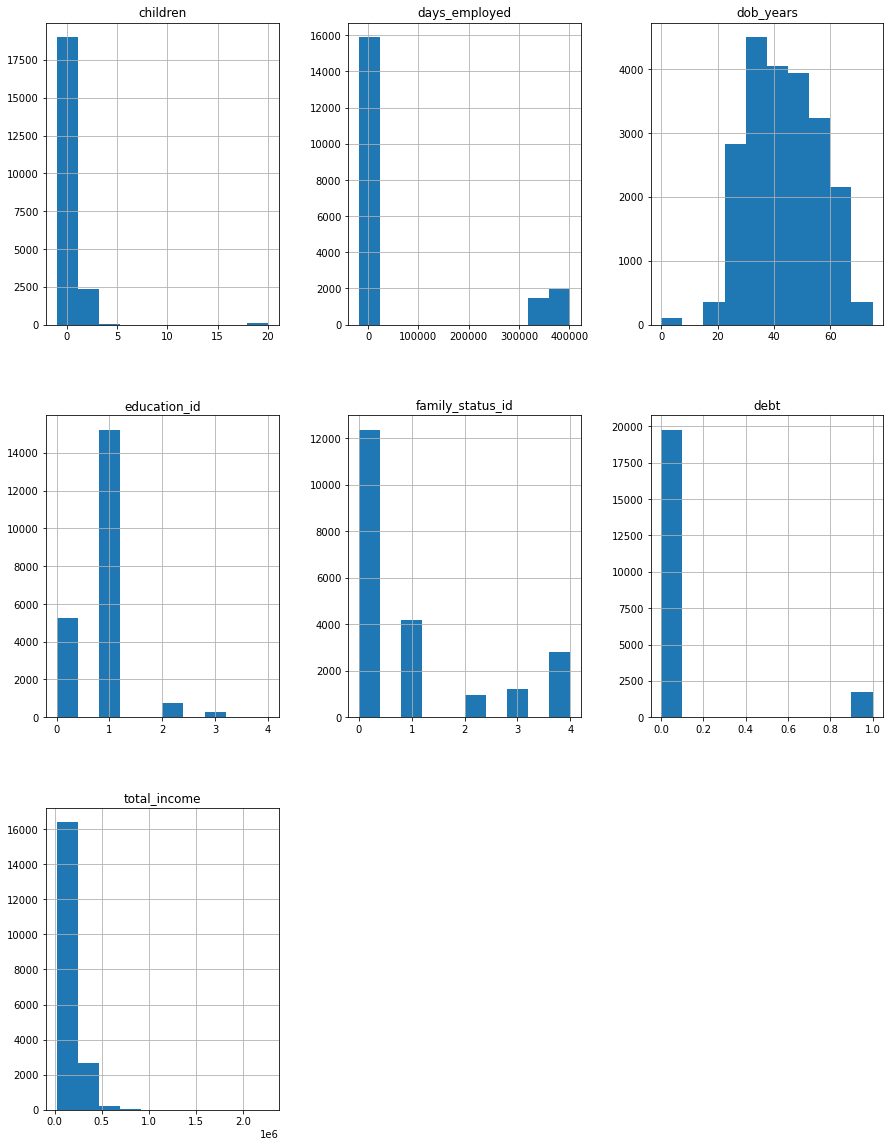

In [4]:
bank_data.hist(figsize=(15,20))
plt.show()

#### Вывод

**Найденные проблемы**
- После первичного анализа данных видно, что в них хватает проблем: например, отрицательное кол-во дней рабочего стажа, или же стаж и доход приведён в к типу float (приведение к типу `int` имеет смысл т.к. нельзя быть трудоустроенным пол рабочего дня, и отсечение дробной части дохода не окажет существенного влияния на кредитный рейтинг, учитывая порядок цифр, так же это сделает данные более читаемыми, сохранит память и ускорит обработку); 
- колонка `education` содержит разные дубликаты; 
- строка `purpose` нуждается в лемматизации и категоризации. 
- Категоризация по уровню образования и семейному статусу проведена не совсем корректно и это нужно исправить. 
- Для колонки `income_type` нужно провести циферную категоризацию. 
- Для колонки `gender` нужно провести циферную категоризацию.
- Колонка `children` имеет отрицательное значение кол-ва детей и выброс в 20 детей.
- Колонка `days_employed` имеет очень сильные выбросы которые равны рабочему стажу около тысячи(!) лет. 

**Из плюсов**:
- имена таблиц записаны корректно; 
- очень больших, труднорешаемых проблем нет.

## Шаг 2. Предобработка данных

### Обработка пропусков и других проблем

In [5]:
# ищем кол-во пропусков в таблице
bank_data.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [6]:
# пристально смотрим на данные, в которых есть пропуски
bank_data[bank_data.days_employed.isnull()].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


##### Исправляем проблемы в колонке `education`:

In [7]:
#смотрим уникальные значения в колонке "образование". 
bank_data.education.unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

In [8]:
#находим дубликаты и убираем их
bank_data.education = bank_data.education.str.lower()
bank_data.education.unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

##### Исправляем проблемы в колонке `days_employed`:

In [9]:
# В данных о кол-ве рабочих дней по ошибке много где выставлены минуса - уберём их
bank_data.days_employed = abs(bank_data.days_employed)
bank_data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [10]:
# пристально смотрим на данные, в которых есть пропуски
bank_data[bank_data.days_employed.isnull()].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


In [11]:
# убираем пропуски в days_employed. Всё работают плюс-минус одинаково, так что можно заполнить медианой
bank_data.days_employed.fillna(bank_data.days_employed.median(), inplace=True)
bank_data.isnull().sum()

children               0
days_employed          0
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

<AxesSubplot:xlabel='days_employed'>

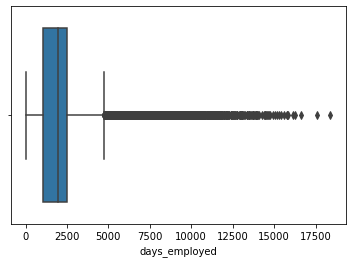

In [12]:
# Пропуски заполнены медианой. Нужно исправить выбросы в колонке "days_employed".
# Предположим, что стаж не может равняться больше 60-ти лет (~22000 дней). Найдём медиану по
# кол-ву рабочих дней исключая данные выбросы и заполным выбросы этой медианой.

days_employed_median_corr = bank_data[bank_data.days_employed<=22000].days_employed.median()
bank_data.days_employed = bank_data.days_employed.apply(lambda x: days_employed_median_corr if x>=22000 else x)
sns.boxplot(x=bank_data.days_employed)

##### Исправляем проблемы в колонке `total_income`:

In [13]:
%%time
# Далеко не самый оптимальный метод, но я пробовал уже и функции с apply() и лямбды, 
# и никак не получалось заставить их корректно работать

# Идея следующая - выставлять всем пропускам медианный доход некорректно, учитывая
# что доход сильно зависит от профессии и образования. В данном методе я выставляю
# пропускам медианный доход согласно их профессии и уровню образования

# проходим по всему массиву
for i in range(len(bank_data)):
    # проверяем является ли income NaN type
    if bank_data.loc[i, 'total_income'] != bank_data.loc[i, 'total_income']:
        # записываем профессию человека
        occupation = bank_data.loc[i, 'income_type']
        # записываем уровень образования человека
        education = bank_data.loc[i, 'education']
        # рассчитываем медианный доход согласно этим двум параметрам
        median_occupation_income = bank_data[(bank_data['income_type']==occupation)
                                             & (bank_data['education']==education)].total_income.median()
        bank_data.loc[i, 'total_income'] = median_occupation_income
bank_data.isnull().sum()

Wall time: 13.7 s


children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

In [14]:
#Пример кода, где я пытался красиво это организовать, но ничего не получилось. Пожалуйста, помогите найти тут ошибку.

def income_median_fill(row):
    income = row['total_income']
    if income!=income: # проверяем является ли income NaN type
        occupation = row['income_type']
        education = row['education']
        income_new = row[(row['income_type']==occupation) & (row['education']==education)].total_income.median()
        return income_new
    return income

#bank_data['total_income'] = bank_data.apply(income_median_fill, axis=1)
#bank_data.isnull().sum()

##### Исправляем проблемы в колонке `children`

In [15]:
bank_data.children.unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

In [16]:
# отрицательные значения явно записаны по ошибке - возьмём данные по модулю
bank_data.children = abs(bank_data.children)
bank_data.children.unique()

array([ 1,  0,  3,  2,  4, 20,  5], dtype=int64)

In [17]:
# двадцати детей тоже явно не может быть, учитывая что прошлое максимально значение - 5.
# Кто-то явно случайно дописал лишний нолик в конце - бывает. Заменим двадцатки двойками.

bank_data.children = bank_data.children.apply(lambda x: 2 if x==20 else x)
bank_data.children.unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

##### Исправляем проблемы в колонке `family_status`
(одно из значений записано с заглавной буквы)

In [18]:
bank_data.family_status.unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [19]:
bank_data.family_status = bank_data.family_status.str.lower()
bank_data.family_status.unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

##### Исправляем проблемы в колонке `dob_years `
(присутствует ноль в некоторых из значений)

In [20]:
bank_data.dob_years.unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75], dtype=int64)

In [21]:
#Выведем кол-во данных значений на экран
len(bank_data[bank_data.dob_years==0])

101

In [22]:
#Выведем данные значения на экран
bank_data[bank_data.dob_years==0].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
99,0,1960.297207,0,среднее,1,женат / замужем,0,F,пенсионер,0,71291.522491,автомобиль
149,0,2664.273168,0,среднее,1,в разводе,3,F,сотрудник,0,70176.435951,операции с жильем
270,3,1872.663186,0,среднее,1,женат / замужем,0,F,сотрудник,0,102166.458894,ремонт жилью
578,0,1960.297207,0,среднее,1,женат / замужем,0,F,пенсионер,0,97620.687042,строительство собственной недвижимости
1040,0,1158.029561,0,высшее,0,в разводе,3,F,компаньон,0,303994.134987,свой автомобиль


Заполнение всех пропущенных значений медианным возрастом будет некорректным. Все категории кроме категории `пенсионер` нужно заполнять медианным возрастом, исключая пенсионеров. Категорию `пенсионер` заполнить медианным возрастом этой же категории.

In [23]:
#находим медианный возраст по всем категориям, кроме пенсионеров
median_age = int(bank_data[bank_data.income_type != 'пенсионер'].dob_years.median())
median_age

39

In [24]:
#находим медианный возраст пенсионеров
median_age_retired = int(bank_data[bank_data.income_type=='пенсионер'].dob_years.median())
median_age_retired

60

In [25]:
# Подскажите, пожалуйста, как это организовать без "предупреждения"?
# Т.к. этот метод работает на порядки быстрее чем с apply(lambda x)
bank_data[(bank_data.dob_years==0) & (bank_data.income_type != 'пенсионер')].dob_years = median_age
bank_data[(bank_data.dob_years==0) & (bank_data.income_type == 'пенсионер')].dob_years = median_age_retired
bank_data.dob_years.unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75], dtype=int64)

In [26]:
# bank_data = bank_data.apply(lambda x: median_age if ((x.dob_years==0) & (x.income_type != 'пенсионер')) else x, axis=1)
# bank_data = bank_data.apply(lambda x: median_age_retired if ((x.dob_years==0) & (x.income_type == 'пенсионер')) else x, axis=1)
# bank_data.dob_years.unique()

**Вывод**

Нашли и убрали дубликаты в колонке об образовании, убрали минуса в колонке о кол-ве рабочих дней и заполнили пропущенные значения согласно медиане. Пропуски в значениях о доходе заполнили медианными значениями согласно профессии и уровню образования. Нули в колонке "возраст" для пенсионеров заполнили медианными значениями возраста пенсионеров, а всем остальным категориям поставили просто медианный возраст. В колонке "семейное положение" привели все значения к нижнему регистру. Отрицательные значения из колонки "кол-во детей" привели к модулю. Заменили выбросы в колонке "стаж" медианным значениями стажа.

Минуса в данных могут появлятся вследствие ошибок и/или опечаток в коде программы, которая выгружала данные. То же самое относится и к выбросам. Ошибки в регистре написания категориальных переменных скорее всего - человеческий фактор.

В итоге мы очистили данные от ошибок и можем приступать к последующей обработке.

### Замена типа данных

In [27]:
# Приведём данные в колонках days_employed и total_income к целочисельным значениям методом .astype(int)

bank_data.days_employed = bank_data.days_employed.astype(int)
bank_data.total_income = bank_data.total_income.astype(int)
bank_data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,1960,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


**Вывод**

Данное преобразование позволит сделать данные более наглядными отсекая ненужные дробные части в колонке days_employed и total_income. Отсечение дробной части в колонке total_income не повлияет на оценку надёжности заёмщика т.к. порядок цифр в доходе довольно большой.

### Лемматизация

Проведём анализ скорости категоризации с помощью лемматизации, стемминга и "по-простому" для колонки `purpose`

In [28]:
# %%time
# # Категоризация с помощью лемматизации

# #функция для лемматизации и соединения слов воедино
# def lemmatize_text(text):
#     m = Mystem()
#     result = m.lemmatize(text)
#     return " ".join(result)

# #категоризируем по лемматизированным словам
# def purpose_category(text):
#     if 'жилье' in lemmatize_text(text):
#         return 1
#     elif 'автомобиль' in lemmatize_text(text):
#         return 2
#     elif 'образование' in lemmatize_text(text):
#         return 3
#     elif 'недвижимость' in lemmatize_text(text):
#         return 4
#     elif 'свадьба' in lemmatize_text(text):
#         return 5
#     else:
#         return 6

# test = bank_data['purpose'].head().apply(purpose_category)

Лемматизация - 13 секунд на 5 строк, это ~ 2.5 секунды на одну строку. Учитывая, что у нас 21 тыс. строк - получится ~ 52 тыс. секунд (~ 15 часов) на обработку всей таблицы с использованием лемматизации. Неприемлемо долго.

In [29]:
%%time
# Категоризация с помощью cтемминга

# определяем стеммер для русского языка
russian_stemmer = SnowballStemmer('russian')

#функция для токенизации текста и стемминга с последующим возвращением текста 
def stemm_text(text):
    token_words = word_tokenize(text)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(russian_stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

# функция для категоризации по стеммингу
def purpose_category(text):
    if 'жил' in stemm_text(text):
        return 1
    elif 'автомобил' in stemm_text(text):
        return 2
    elif 'образован' in stemm_text(text):
        return 3
    elif 'недвижим' in stemm_text(text):
        return 4
    elif 'свадьб' in stemm_text(text):
        return 5
    else:
        return 6
    
test = bank_data['purpose'].apply(purpose_category)

Wall time: 16.4 s


Получается на порядки быстрее лемматизации (приблизительно 13 секунд на всю таблицу).

In [30]:
%%time

# Категоризация "по-простому" - поиск подстрок в тексте

def purpose_category(text):
    if 'жиль' in text:
        return 1
    elif 'автомобил' in text:
        return 2
    elif 'образовани' in text:
        return 3
    elif 'недвижимост' in text:
        return 4
    elif 'свадьб' in text:
        return 5
    else:
        return 6

test = bank_data['purpose'].apply(purpose_category)

Wall time: 19 ms


"По-простому" получается на порядки быстрее лемматизации и стемминга (пара миллисекунд на всю таблицу). Данный метод не такой надёжный как лемматизация, но по результату будет ничем не хуже стемминга. Пожалуй, будем использовать этот метод.

**Вывод**

Лемматизация (по крайней мере на моём ноутбуке) работает слишком долго для того чтобы был смысл её применить к данной задаче.
А стемминг по результату не будет отличаться от простого поиска подстроки.

### Категоризация данных

##### Категоризируем колонку `purpose`

In [31]:
# Категоризируем колонку purpose "по-простому":
bank_data['purpose_id'] = bank_data['purpose'].apply(purpose_category)
bank_data[['purpose', 'purpose_id']].head(10)

,purpose,purpose_id
0,покупка жилья,1
1,приобретение автомобиля,2
2,покупка жилья,1
3,дополнительное образование,3
4,сыграть свадьбу,5
5,покупка жилья,1
6,операции с жильем,1
7,образование,3
8,на проведение свадьбы,5
9,покупка жилья для семьи,1


##### Категоризируем колонку `days_employed`

In [32]:
#Категоризация по колонке days_employed с помощью квартилей. Определяем квартили.
quant_cat_empl = bank_data.days_employed.quantile([.25, .5, 0.75, 1])

In [33]:
#Категоризация по колонке days_employed с помощью квартилей
bank_data['days_employed_id'] = bank_data.apply(lambda x: 1 if x.days_employed<=quant_cat_empl[.25]
                                                                   else 2 if x.days_employed<=quant_cat_empl[.5]
                                                                   else 3 if x.days_employed<=quant_cat_empl[.75]
                                                                   else 4, axis=1)
bank_data[['days_employed', 'days_employed_id']].tail()

,days_employed,days_employed_id
21520,4529,4
21521,1960,2
21522,2113,3
21523,3112,4
21524,1984,3


##### Категоризируем колонку `total_income`

In [34]:
#Категоризация по колонке total_income с помощью квартилей. Определяем квартили.
quant_cat_income = bank_data.total_income.quantile([.25, .5, 0.75, 1])

In [35]:
#Категоризация по колонке total_income с помощью квартилей
bank_data['total_income_id'] = bank_data.apply(lambda x: 1 if x.total_income<=quant_cat_income[.25]
                                                                   else 2 if x.total_income<=quant_cat_income[.5]
                                                                   else 3 if x.total_income<=quant_cat_income[.75]
                                                                   else 4, axis=1)
bank_data[['total_income', 'total_income_id']].head()

,total_income,total_income_id
0,253875,4
1,112080,2
2,145885,3
3,267628,4
4,158616,3


##### Категоризируем колонку `education`

In [36]:
# Категоризация данных из колонки "education". Посмотрим кол-во уникальных значений.
bank_data.education.unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [37]:
def education_cat(row):
    education = row['education']
    if education == 'начальное':
        return 0
    elif education == 'среднее':
        return 1
    elif education == 'неоконченное высшее':
        return 2
    elif education == 'высшее':
        return 3
    return 4

bank_data['education_id'] = bank_data.apply(education_cat, axis=1)
bank_data[['education', 'education_id']].head()

,education,education_id
0,высшее,3
1,среднее,1
2,среднее,1
3,среднее,1
4,среднее,1


In [38]:
bank_data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_id,days_employed_id,total_income_id
0,1,8437,42,высшее,3,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,1,4,4
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,2,4,2
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,1,4,3
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,3,4,4
4,0,1960,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,5,2,3


##### Категоризируем колонку `gender`

In [39]:
bank_data.gender.unique()

array(['F', 'M', 'XNA'], dtype=object)

In [40]:
bank_data['gender_id'] = bank_data.gender.apply(lambda x: 1 if x=='M' else 2 if x=='F' else 3 if x=='XNA' else x)
bank_data[['gender', 'gender_id']].head()

,gender,gender_id
0,F,2
1,F,2
2,M,1
3,M,1
4,F,2


##### Категоризируем колонку `income_type`

In [41]:
bank_data.income_type.unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

In [42]:
bank_data['income_type_id'] = bank_data.income_type.apply(lambda x: 0 if x=='безработный'
                                                          else 1 if x=='студент'
                                                          else 2 if x=='в декрете'
                                                          else 3 if x=='компаньон'
                                                          else 4 if x=='сотрудник'
                                                          else 5 if x=='госслужащий'
                                                          else 6 if x=='предприниматель'
                                                          else 7 if x=='пенсионер' else x)
bank_data[['income_type', 'income_type_id']].tail()

,income_type,income_type_id
21520,компаньон,3
21521,пенсионер,7
21522,сотрудник,4
21523,сотрудник,4
21524,сотрудник,4


##### Категоризируем колонку `dob_years`

In [43]:
bank_data['dob_years_id'] = bank_data['dob_years'].apply(lambda x: 0 if x<=17
                                                        else 1 if x<=30
                                                        else 2 if x<=60
                                                        else 3)
bank_data[['dob_years', 'dob_years_id']].tail()

,dob_years,dob_years_id
21520,43,2
21521,67,3
21522,38,2
21523,38,2
21524,40,2


##### Смотрим на полученные данные

In [44]:
bank_data = bank_data.reindex(sorted(bank_data.columns), axis=1)
bank_data.head()

,children,days_employed,days_employed_id,debt,dob_years,dob_years_id,education,education_id,family_status,family_status_id,gender,gender_id,income_type,income_type_id,purpose,purpose_id,total_income,total_income_id
0,1,8437,4,0,42,2,высшее,3,женат / замужем,0,F,2,сотрудник,4,покупка жилья,1,253875,4
1,1,4024,4,0,36,2,среднее,1,женат / замужем,0,F,2,сотрудник,4,приобретение автомобиля,2,112080,2
2,0,5623,4,0,33,2,среднее,1,женат / замужем,0,M,1,сотрудник,4,покупка жилья,1,145885,3
3,3,4124,4,0,32,2,среднее,1,женат / замужем,0,M,1,сотрудник,4,дополнительное образование,3,267628,4
4,0,1960,2,0,53,2,среднее,1,гражданский брак,1,F,2,пенсионер,7,сыграть свадьбу,5,158616,3


**Вывод**

Занялись категоризацией всех нужных колонок и успешно её провели. Отсортировали имена колонок по имени.

### Посмотрим на медианный доход в зависимости от образования и текущей профессии

In [45]:
bank_data.pivot_table('total_income', index=bank_data.education_id, columns='income_type', aggfunc='median')

income_type,безработный,в декрете,госслужащий,компаньон,пенсионер,предприниматель,сотрудник,студент
education_id,,,,,,,,
0,NaN,NaN,148339.0,136798.0,102598.0,NaN,125994.0,NaN
1,59956.0,53829.0,136652.0,159070.0,114842.0,NaN,136555.0,NaN
2,NaN,NaN,160592.0,179867.0,120136.0,NaN,151308.0,NaN
3,202722.0,NaN,172511.0,201785.0,144240.0,499163.0,165640.0,98201.0
4,NaN,NaN,111392.0,NaN,177088.5,NaN,198570.0,NaN


## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

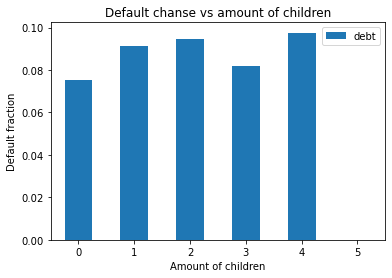

In [46]:
#titanic.pivot_table('debt', index='children', columns='class')
bank_data.groupby('children')['debt'].mean().sort_values().to_frame().sort_values('children').plot(kind='bar', rot=0)
plt.title('Default chanse vs amount of children')
plt.xlabel('Amount of children')
plt.ylabel('Default fraction')
plt.show()

In [47]:
len(bank_data[bank_data['children']==5])

9

**Вывод**

Как видим из данной таблицы, люди, у которых 5 детей, отдают кредиты всегда. Это объясняется слишком маленькой выборкой - всего 9 человек, в то время как людей, у которых один ребёнок - 4865. Из репрезентативных данных видно, что чаще всего отдают кредиты люди у которых нет детей. В то же время, люди у которых три ребёнка, отдают кредиты чаще чем люди, у которых 1, 2 и 4 детей.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

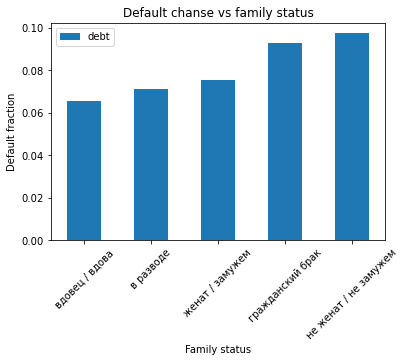

In [48]:
bank_data.groupby('family_status')['debt'].mean().sort_values().to_frame().sort_values('debt').plot(kind='bar', rot=45)
plt.title('Default chanse vs family status')
plt.xlabel('Family status')
plt.ylabel('Default fraction')
plt.show()

**Вывод**

Как видим из таблицы, вдовы и вдовцы отдают кредиты чаще всего, а одинокие люди (не женат / не замужем) - реже всего.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

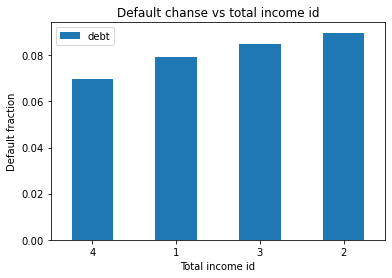

In [49]:
bank_data.groupby('total_income_id')['debt'].mean().sort_values().to_frame().sort_values('debt').plot(kind='bar', rot=0)
plt.title('Default chanse vs total income id')
plt.xlabel('Total income id')
plt.ylabel('Default fraction')
plt.show()

**Вывод**

Из представленных данных видно, что люди с доходом из четвёртого квартиля (самый высокий доход) отдают кредиты чаще всего, после них сразу же идут люди с самым низким уровнем дохода. Хуже всего отдают кредиты люди с доходом из второго квартиля.

- Как разные цели кредита влияют на его возврат в срок?

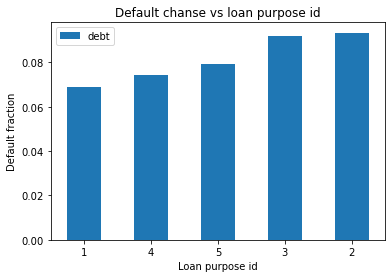

In [50]:
# жилье: 1; автомобиль: 2; образование: 3; недвижимость: 4; свадьба: 5; другое: 6
bank_data.groupby('purpose_id')['debt'].mean().sort_values().to_frame().sort_values('debt').plot(kind='bar', rot=0)
plt.title('Default chanse vs loan purpose id')
plt.xlabel('Loan purpose id')
plt.ylabel('Default fraction')
plt.show()

**Вывод**

Данные показывают, что люди, которые берут ипотеку, отдают долги чаще всех остальных категорий. Хуже всего отдают кредиты, взятые на покупку автомобиля.

## Шаг 4. Общий вывод

Данные, предоставленные к обработке, содержали пропуски, ошибки и выбросы. Также, отсутствовала категоризация по ряду колонок, в том числе по цели кредита. Все эти проблемы успешно исправлены и даны ответы на возврат кредитов в зависимости от дохода, семейного положения и т.д. 
Проект готов к отправке заказчику.